# Задача 2. Логистическая регрессия (LogReg)

В этом ноутбуке мы создаем и оцениваем модель **логистической регрессии**.  
Мы работаем с **предобработанными данными** из `preprocess_ilsiya.ipynb`.  

- Train используется для построения модели и кросс-валидации.  
- Test откладываем для финальной оценки.  
- Рассматриваем работу с дисбалансом классов через `class_weight`.  
- Подбираем гиперпараметры (`C`, `penalty`, `solver`) с помощью GridSearchCV на Stratified K-Fold.  
- Строим график важности признаков.



## 1. Указание импортов

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score



## 2. Загрузка предобработанных данных

Результаты предобработки (`X_train_processed_df`, `X_test_processed_df`, `y_train`, `y_test`) в ноутбуке  `preprocess_ilsiya.ipynb` сохранены с помощью pickle, чтобы использовать их здесь.  

```python
X_train_processed_df.to_pickle('X_train.pkl')
X_test_processed_df.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')


In [4]:

X_train_processed_df = pd.read_pickle('X_train.pkl')
X_test_processed_df = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

print("Train shape:", X_train_processed_df.shape)
print("Test shape:", X_test_processed_df.shape)

Train shape: (6324, 21)
Test shape: (1581, 21)


## 3. Бинаризация целевой переменной

В нашем датасете `Status` может принимать значения `C`, `D`, `CL`.  
мы преобразуем эти значения в:

- `C` → 0  
- `D`, `CL` → 1


In [5]:
y_train_bin = (y_train != 'C').astype(int)
y_test_bin = (y_test != 'C').astype(int)

print("Распределение классов Train:", y_train_bin.value_counts().to_dict())
print("Распределение классов Test:", y_test_bin.value_counts().to_dict())

Распределение классов Train: {0: 3972, 1: 2352}
Распределение классов Test: {0: 993, 1: 588}


## 4. Определение модели логистической регрессии

- `multi_class='multinomial'` для многоклассовой задачи  
- `max_iter=5000` чтобы гарантировать сходимость  
- `random_state=42` для воспроизводимости


In [6]:

logreg = LogisticRegression(max_iter=5000, random_state=42)


## 5. Подбор гиперпараметров через GridSearchCV

Осуществляется подбор:  
- `C` (коэффициент регуляризации)  
- `penalty` (тип штрафа, только l2, т.к. solver='lbfgs')  
- `solver` (алгоритм оптимизации, используем 'lbfgs')  
- `class_weight` (`None` и `'balanced'` для работы с дисбалансом классов)


In [7]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': [None, 'balanced']
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)


## 6. Обучаем GridSearch на train

Ищем лучшие гиперпараметры на тренировочной выборке.

In [8]:
grid_search.fit(X_train_processed_df, y_train_bin)

best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


## 7. Оценка на train через cross_val_predict

Используем Stratified K-Fold для корректной оценки на train.  
Метрики: F1, precision, recall.


=== Train Metrics ===
              precision    recall  f1-score   support

           0     0.8297    0.9006    0.8637      3972
           1     0.8038    0.6879    0.7414      2352

    accuracy                         0.8215      6324
   macro avg     0.8168    0.7942    0.8025      6324
weighted avg     0.8201    0.8215    0.8182      6324



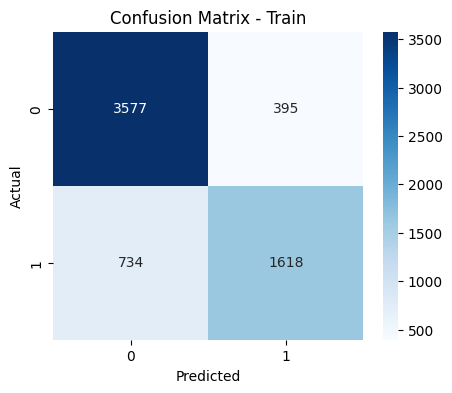

In [10]:
y_train_pred = cross_val_predict(best_model, X_train_processed_df, y_train_bin, cv=skf)

print("=== Train Metrics ===")
print(classification_report(y_train_bin, y_train_pred, digits=4))

cm_train = confusion_matrix(y_train_bin, y_train_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Train')
plt.show()

## 8. Финальное обучение и оценка на test


=== Test Metrics ===
              precision    recall  f1-score   support

           0     0.8412    0.8802    0.8602       993
           1     0.7804    0.7194    0.7487       588

    accuracy                         0.8204      1581
   macro avg     0.8108    0.7998    0.8045      1581
weighted avg     0.8186    0.8204    0.8187      1581



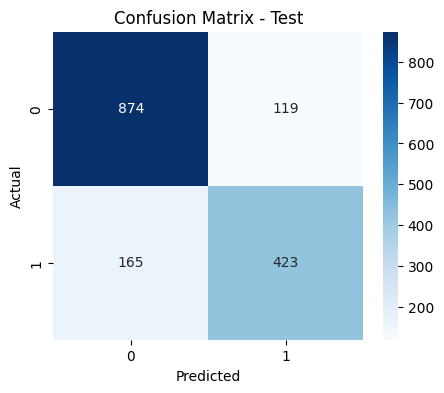

In [11]:
best_model.fit(X_train_processed_df, y_train_bin)

y_test_pred = best_model.predict(X_test_processed_df)

print("=== Test Metrics ===")
print(classification_report(y_test_bin, y_test_pred, digits=4))

cm_test = confusion_matrix(y_test_bin, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test')
plt.show()



## 9. Feature Importance

Выводим коэффициенты **со знаком**, т.к. знак показывает направление влияния:
- положительный коэффициент → рост признака повышает вероятность класса 1 (D/CL)
- отрицательный коэффициент → рост признака снижает вероятность класса 1 (т.е. связан с C)


C:\Users\radaev\AppData\Local\Temp\ipykernel_17156\1938912721.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


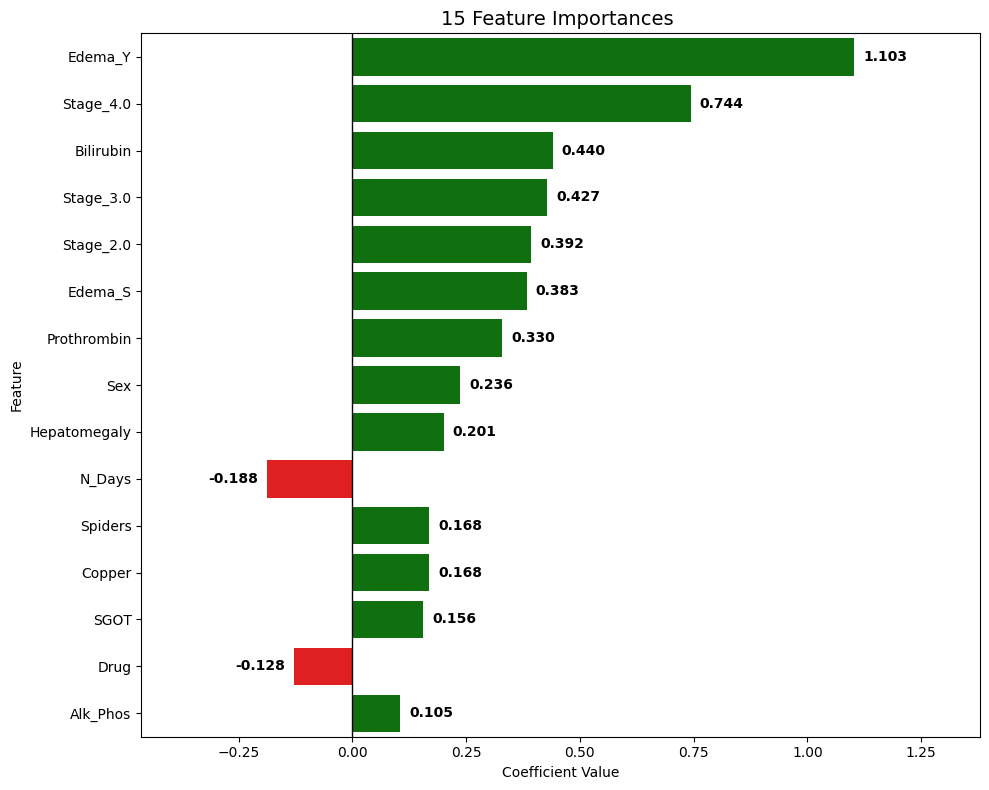

=== 15 Most Important Features ===

     feature      coef
     Edema_Y  1.103291
   Stage_4.0  0.743543
   Bilirubin  0.440234
   Stage_3.0  0.427181
   Stage_2.0  0.392034
     Edema_S  0.382681
 Prothrombin  0.329574
         Sex  0.236061
Hepatomegaly  0.200505
      N_Days -0.188015
     Spiders  0.168326
      Copper  0.168172
        SGOT  0.155736
        Drug -0.127817
    Alk_Phos  0.105154


In [35]:
top_n = 15

coefs = best_model.coef_.flatten()
final_feature_names = X_train_processed_df.columns

importance = (
    pd.DataFrame({"feature": final_feature_names, "coef": coefs})
    .sort_values(by="coef", key=lambda x: x.abs(), ascending=False)
)

top_features = importance.head(top_n)


colors = ["green" if c > 0 else "red" for c in top_features["coef"]]

plt.figure(figsize=(10, 8))

ax = sns.barplot(
    data=top_features,
    x="coef",
    y="feature",
    palette=colors
)

max_coef = top_features["coef"].max()
min_coef = top_features["coef"].min()
margin = (max(abs(max_coef), abs(min_coef))) * 0.25
plt.xlim(min_coef - margin, max_coef + margin)


for i, row in top_features.iterrows():
    coef = row["coef"]
    plt.text(
        coef + (0.02 if coef > 0 else -0.02),
        list(top_features.index).index(i),
        f"{coef:.3f}",
        va="center",
        ha="left" if coef > 0 else "right",
        fontsize=10,
        fontweight="bold"
    )

plt.title(f"{top_n} Feature Importances ", fontsize=14)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()


print(f"=== {top_n} Most Important Features ===\n")
print(top_features.to_string(index=False))


